# **A Suite of VAMPIRE-X Models With Different Thresholds**

We create a suite of VAMPIRE-X Models, each with a different alert thresold derived from percentiles of the distrbution of the maximum 1.8MeV Electron flux in the Outer Radiation Belt.
 This notebook will train these models, or pull pre-trained models from a Zenodo repository.
  The created models are:
*   VAMPIRE-X60 (Threshold at the 60th Percentile ~$10^{5.86}$pfu)
*   VAMPIRE-X70 (Threshold at the 70th Percentile ~$10^{6.05}$pfu)
*   VAMPIRE-X80 (Threshold at the 80th Percentile ~$10^{6.26}$pfu)
*   VAMPIRE-X90 (Threshold at the 90th Percentile ~$10^{6.57}$pfu)
*   VAMPIRE-X95 (Threshold at the 95th Percentile ~$10^{6.78}$pfu)

In [ ]:
#Install all the packages
!pip install numpy==1.26.0
!pip install matplotlib==3.8.0
!pip install scikit-learn==1.6.1
!pip install tqdm==4.66.1
!pip install joblib==1.3.2
!pip install pandas==2.1.1
!pip install wget

In [ ]:
# Importing all the required packages
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import joblib
from tqdm import tqdm
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from datetime import datetime, timedelta
import pandas as pd
import wget

# Importing the Training and Testing Sets
Import the training and testing datasets, these are stored in a zenodo repositary and can be downloaded straight from there.

We use a chronological split to form the training and test sets, with the first $\frac{2}{3}$ forming the training set and the remaining forming the testing set, this gives us a training set from 25/09/12 to 01/07/2017 and a testing set from 02/07/2017 to 16/07/2019

In [ ]:
#Pulling the training dataset from zenodo

training_data=pd.read_hdf(wget.download("https://zenodo.org/records/17062872/files/VAMPIRE-X_Suite_training_data.h5"))

training_data.head()

,AL_mean_1_delay,AL_mean_3_delay,AL_mean_4_delay,AL_median_5_delay,AL_max_6_delay,AL_mean_7_delay,epoch,flux,X60 Class,X70 Class,X80 Class,X90 Class,X95 Class
0,-18.520833,-19.197917,-72.329861,-49.5,-818,-72.159722,2012-09-25 12:00:00,136310.78240,0,0,0,0,0
1,-18.479167,-18.770833,-19.197917,-33.0,-374,-234.600694,2012-09-26 12:00:00,132436.05610,0,0,0,0,0
2,-48.934028,-18.520833,-18.770833,-18.0,-387,-71.149306,2012-09-27 12:00:00,108839.06490,0,0,0,0,0
3,-24.746528,-18.479167,-18.520833,-20.0,-73,-72.329861,2012-09-28 12:00:00,103772.71340,0,0,0,0,0
4,-26.156250,-48.934028,-18.479167,-18.0,-32,-19.197917,2012-09-29 12:00:00,94741.10091,0,0,0,0,0


In [ ]:
#Pulling the test dataset from zenodo

testing_data=pd.read_hdf(wget.download("https://zenodo.org/records/17062872/files/VAMPIRE-X_Suite_testing_data.h5"))
testing_data.head()

,AL_mean_1_delay,AL_mean_3_delay,AL_mean_4_delay,AL_median_5_delay,AL_max_6_delay,AL_mean_7_delay,epoch,flux,X60 Class,X70 Class,X80 Class,X90 Class,X95 Class
0,-150.986111,-28.079861,-57.298611,-56.5,-320,-99.145833,2017-07-02 12:00:00,98855.35787,0,0,0,0,0
1,-44.868056,-86.138889,-28.079861,-24.0,-267,-67.750000,2017-07-03 12:00:00,68275.90869,0,0,0,0,0
2,-48.944444,-150.986111,-86.138889,-21.0,-369,-66.579861,2017-07-04 12:00:00,64634.91314,0,0,0,0,0
3,-52.131944,-44.868056,-150.986111,-34.5,-130,-57.298611,2017-07-05 12:00:00,65847.51708,0,0,0,0,0
4,-36.260417,-48.944444,-44.868056,-105.5,-673,-28.079861,2017-07-06 12:00:00,56815.46454,0,0,0,0,0


In [ ]:
# Defining Model inputs for each model and lead time
all_inputs=[
        [#60
         #nowcast
        ['AL_mean_1_delay', 'AL_mean_3_delay', 'AL_mean_4_delay',  'AL_median_5_delay',  'AL_max_6_delay',  'AL_mean_7_delay'],
        #1-day lead time
        ['AL_mean_3_delay', 'AL_mean_4_delay',  'AL_median_5_delay',  'AL_max_6_delay',  'AL_mean_7_delay'],
        #2-day lead time
        ['AL_mean_3_delay', 'AL_mean_4_delay',  'AL_median_5_delay',  'AL_max_6_delay',  'AL_mean_7_delay'],
        #3-day lead time
        ['AL_mean_4_delay',  'AL_median_5_delay',  'AL_max_6_delay',  'AL_mean_7_delay'],
        #4-day lead time
        ['AL_median_5_delay',  'AL_max_6_delay',  'AL_mean_7_delay'],
        #5-day lead time
        ['AL_max_6_delay',  'AL_mean_7_delay'],
        #6-day lead time
        ['AL_mean_7_delay']
         ],
        [#70
         #nowcast
         ['AL_mean_1_delay', 'AL_mean_3_delay',   'AL_max_6_delay',  'AL_mean_7_delay'],
         #1-day lead time
         [ 'AL_mean_3_delay',   'AL_max_6_delay',  'AL_mean_7_delay'],
         #2-day lead time
         [ 'AL_mean_3_delay',   'AL_max_6_delay',  'AL_mean_7_delay'],
         #3-day lead time
         [ 'AL_max_6_delay',  'AL_mean_7_delay'],
         #4-day lead time
         [ 'AL_max_6_delay',  'AL_mean_7_delay'],
         #5-day lead time
         [ 'AL_max_6_delay',  'AL_mean_7_delay'],
         #6-day lead time
         [  'AL_mean_7_delay']
         ],
        [#80
         #nowcast
         ['AL_mean_1_delay', 'AL_mean_3_delay', 'AL_mean_4_delay',  'AL_median_5_delay',   'AL_mean_7_delay'],
         #1-day lead time
         ['AL_mean_3_delay', 'AL_mean_4_delay',  'AL_median_5_delay',   'AL_mean_7_delay'],
         #2-day lead time
         ['AL_mean_3_delay', 'AL_mean_4_delay',  'AL_median_5_delay',   'AL_mean_7_delay'],
         #3-day lead time
         ['AL_mean_4_delay',  'AL_median_5_delay',   'AL_mean_7_delay'],
         #4-day lead time
         ['AL_median_5_delay',   'AL_mean_7_delay'],
         #5-day lead time
         ['AL_mean_7_delay'],
         #6-day lead time
         ['AL_mean_7_delay']
         ],
        [#90
         #nowcast
         ['AL_mean_1_delay', 'AL_mean_3_delay', 'AL_mean_4_delay',  'AL_median_5_delay',   'AL_mean_7_delay'],
         #1-day lead time
         [ 'AL_mean_3_delay', 'AL_mean_4_delay',  'AL_median_5_delay',   'AL_mean_7_delay'],
         #2-day lead time
         [ 'AL_mean_3_delay', 'AL_mean_4_delay',  'AL_median_5_delay',   'AL_mean_7_delay'],
         #3-day lead time
         ['AL_mean_4_delay',  'AL_median_5_delay',   'AL_mean_7_delay'],
         #4-day lead time
         ['AL_median_5_delay',   'AL_mean_7_delay'],
         #5-day lead time
         ['AL_mean_7_delay'],
         #6-day lead time
         ['AL_mean_7_delay']
            ],
        [#95
         #nowcast
         ['AL_mean_1_delay', 'AL_mean_3_delay',   'AL_median_5_delay',   'AL_mean_7_delay'],
         #1-day lead time
         ['AL_mean_3_delay',   'AL_median_5_delay',   'AL_mean_7_delay'],
         #2-day lead time
         ['AL_mean_3_delay',   'AL_median_5_delay',   'AL_mean_7_delay'],
         #3-day lead time
         [ 'AL_median_5_delay',   'AL_mean_7_delay'],
         #4-day lead time
         [ 'AL_median_5_delay',   'AL_mean_7_delay'],
         #5-day lead time
         [ 'AL_mean_7_delay'],
         #6-day lead time
         [ 'AL_mean_7_delay'],
            ]
        ]



In [ ]:
# Obtain Pre-Trained Forests from Zenodo

lead_time_0_days_X60=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_60_0-day_leadtime_pretrained_forest.joblib'))
lead_time_1_days_X60=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_60_1-day_leadtime_pretrained_forest.joblib'))
lead_time_2_days_X60=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_60_2-day_leadtime_pretrained_forest.joblib'))
lead_time_3_days_X60=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_60_3-day_leadtime_pretrained_forest.joblib'))
lead_time_4_days_X60=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_60_4-day_leadtime_pretrained_forest.joblib'))
lead_time_5_days_X60=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_60_5-day_leadtime_pretrained_forest.joblib'))
lead_time_6_days_X60=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_60_6-day_leadtime_pretrained_forest.joblib'))

lead_time_0_days_X70=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_70_0-day_leadtime_pretrained_forest.joblib'))
lead_time_1_days_X70=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_70_1-day_leadtime_pretrained_forest.joblib'))
lead_time_2_days_X70=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_70_2-day_leadtime_pretrained_forest.joblib'))
lead_time_3_days_X70=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_70_3-day_leadtime_pretrained_forest.joblib'))
lead_time_4_days_X70=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_70_4-day_leadtime_pretrained_forest.joblib'))
lead_time_5_days_X70=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_70_5-day_leadtime_pretrained_forest.joblib'))
lead_time_6_days_X70=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_70_6-day_leadtime_pretrained_forest.joblib'))

lead_time_0_days_X80=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_80_0-day_leadtime_pretrained_forest.joblib'))
lead_time_1_days_X80=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_80_1-day_leadtime_pretrained_forest.joblib'))
lead_time_2_days_X80=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_80_2-day_leadtime_pretrained_forest.joblib'))
lead_time_3_days_X80=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_80_3-day_leadtime_pretrained_forest.joblib'))
lead_time_4_days_X80=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_80_4-day_leadtime_pretrained_forest.joblib'))
lead_time_5_days_X80=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_80_5-day_leadtime_pretrained_forest.joblib'))
lead_time_6_days_X80=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_80_6-day_leadtime_pretrained_forest.joblib'))

lead_time_0_days_X90=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_90_0-day_leadtime_pretrained_forest.joblib'))
lead_time_1_days_X90=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_90_1-day_leadtime_pretrained_forest.joblib'))
lead_time_2_days_X90=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_90_2-day_leadtime_pretrained_forest.joblib'))
lead_time_3_days_X90=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_90_3-day_leadtime_pretrained_forest.joblib'))
lead_time_4_days_X90=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_90_4-day_leadtime_pretrained_forest.joblib'))
lead_time_5_days_X90=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_90_5-day_leadtime_pretrained_forest.joblib'))
lead_time_6_days_X90=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_90_6-day_leadtime_pretrained_forest.joblib'))

lead_time_0_days_X95=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_95_0-day_leadtime_pretrained_forest.joblib'))
lead_time_1_days_X95=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_95_1-day_leadtime_pretrained_forest.joblib'))
lead_time_2_days_X95=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_95_2-day_leadtime_pretrained_forest.joblib'))
lead_time_3_days_X95=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_95_3-day_leadtime_pretrained_forest.joblib'))
lead_time_4_days_X95=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_95_4-day_leadtime_pretrained_forest.joblib'))
lead_time_5_days_X95=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_95_5-day_leadtime_pretrained_forest.joblib'))
lead_time_6_days_X95=joblib.load(wget.download('https://zenodo.org/records/17062872/files/VAMPIRE-X_95_6-day_leadtime_pretrained_forest.joblib'))



In [ ]:
# Training Forests from scratch

### VAMPIRE-X60 ###
lead_time_0_days_X60=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[0][0]],training_data['X60 Class'])
lead_time_1_days_X60=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[0][1]],training_data['X60 Class'])
lead_time_2_days_X60=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[0][2]],training_data['X60 Class'])
lead_time_3_days_X60=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[0][3]],training_data['X60 Class'])
lead_time_4_days_X60=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[0][4]],training_data['X60 Class'])
lead_time_5_days_X60=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[0][5]],training_data['X60 Class'])
lead_time_6_days_X60=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[0][6]],training_data['X60 Class'])

### VAMPIRE-X70 ###
lead_time_0_days_X70=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[1][0]],training_data['X70 Class'])
lead_time_1_days_X70=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[1][1]],training_data['X70 Class'])
lead_time_2_days_X70=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[1][2]],training_data['X70 Class'])
lead_time_3_days_X70=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[1][3]],training_data['X70 Class'])
lead_time_4_days_X70=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[1][4]],training_data['X70 Class'])
lead_time_5_days_X70=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[1][5]],training_data['X70 Class'])
lead_time_6_days_X70=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[1][6]],training_data['X70 Class'])

### VAMPIRE-X80 ###
lead_time_0_days_X80=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[2][0]],training_data['X80 Class'])
lead_time_1_days_X80=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[2][1]],training_data['X80 Class'])
lead_time_2_days_X80=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[2][2]],training_data['X80 Class'])
lead_time_3_days_X80=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[2][3]],training_data['X80 Class'])
lead_time_4_days_X80=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[2][4]],training_data['X80 Class'])
lead_time_5_days_X80=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[2][5]],training_data['X80 Class'])
lead_time_6_days_X80=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[2][6]],training_data['X80 Class'])

### VAMPIRE-X90 ###
lead_time_0_days_X90=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[3][0]],training_data['X90 Class'])
lead_time_1_days_X90=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[3][1]],training_data['X90 Class'])
lead_time_2_days_X90=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[3][2]],training_data['X90 Class'])
lead_time_3_days_X90=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[3][3]],training_data['X90 Class'])
lead_time_4_days_X90=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[3][4]],training_data['X90 Class'])
lead_time_5_days_X90=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[3][5]],training_data['X90 Class'])
lead_time_6_days_X90=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[3][6]],training_data['X90 Class'])

### VAMPIRE-X95 ###
lead_time_0_days_X95=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[4][0]],training_data['X95 Class'])
lead_time_1_days_X95=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[4][1]],training_data['X95 Class'])
lead_time_2_days_X95=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[4][2]],training_data['X95 Class'])
lead_time_3_days_X95=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[4][3]],training_data['X95 Class'])
lead_time_4_days_X95=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[4][4]],training_data['X95 Class'])
lead_time_5_days_X95=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[4][5]],training_data['X95 Class'])
lead_time_6_days_X95=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[all_inputs[4][6]],training_data['X95 Class'])



In [ ]:
 # This stores all of these models in a list-of-lists for easy access later
suite=[
    #VAMPIRE-X60
    [lead_time_0_days_X60,lead_time_1_days_X60,lead_time_2_days_X60,lead_time_3_days_X60,lead_time_4_days_X60,lead_time_5_days_X60,lead_time_6_days_X60],
    #VAMPIRE-X70
    [lead_time_0_days_X70,lead_time_1_days_X70,lead_time_2_days_X70,lead_time_3_days_X70,lead_time_4_days_X70,lead_time_5_days_X70,lead_time_6_days_X70],
    #VAMPIRE-X80
    [lead_time_0_days_X80,lead_time_1_days_X80,lead_time_2_days_X80,lead_time_3_days_X80,lead_time_4_days_X80,lead_time_5_days_X80,lead_time_6_days_X80],
    #VAMPIRE-X90
    [lead_time_0_days_X90,lead_time_1_days_X90,lead_time_2_days_X90,lead_time_3_days_X90,lead_time_4_days_X90,lead_time_5_days_X90,lead_time_6_days_X90],
    #VAMPIRE-X95
    [lead_time_0_days_X95,lead_time_1_days_X95,lead_time_2_days_X95,lead_time_3_days_X95,lead_time_4_days_X95,lead_time_5_days_X95,lead_time_6_days_X95],
]

# Testing the Forests



In [ ]:
#Select the assessment period
#Start and End should be edited to the desired start and end dates in the form YYYY-MM-DD
#The earliest start date should be 2017-07-02

Start= '2017-07-02'

#The latest end date should be 2019-07-16

End='2019-07-16'


#We now pull the desired portions of the testing set

start_index=np.where( testing_data['epoch']==Start+' 12:00:00')[0][0]
end_index=np.where( testing_data['epoch']==End+' 12:00:00')[0][0]+7

selected_testing_data=testing_data.iloc[start_index:end_index]
selected_testing_data.head()

selected_testing_data.head(n=20)

,AL_mean_1_delay,AL_mean_3_delay,AL_mean_4_delay,AL_median_5_delay,AL_max_6_delay,AL_mean_7_delay,epoch,flux,X60 Class,X70 Class,X80 Class,X90 Class,X95 Class
0,-150.986111,-28.079861,-57.298611,-56.5,-320,-99.145833,2017-07-02 12:00:00,9.885536e+04,0,0,0,0,0
1,-44.868056,-86.138889,-28.079861,-24.0,-267,-67.750000,2017-07-03 12:00:00,6.827591e+04,0,0,0,0,0
2,-48.944444,-150.986111,-86.138889,-21.0,-369,-66.579861,2017-07-04 12:00:00,6.463491e+04,0,0,0,0,0
3,-52.131944,-44.868056,-150.986111,-34.5,-130,-57.298611,2017-07-05 12:00:00,6.584752e+04,0,0,0,0,0
4,-36.260417,-48.944444,-44.868056,-105.5,-673,-28.079861,2017-07-06 12:00:00,5.681546e+04,0,0,0,0,0
5,-89.878472,-52.131944,-48.944444,-29.5,-876,-86.138889,2017-07-07 12:00:00,5.199389e+04,0,0,0,0,0
6,-49.250000,-36.260417,-52.131944,-28.0,-359,-150.986111,2017-07-08 12:00:00,5.234600e+04,0,0,0,0,0
7,-114.291667,-89.878472,-36.260417,-32.0,-268,-44.868056,2017-07-09 12:00:00,5.386580e+04,0,0,0,0,0
8,-166.163194,-49.250000,-89.878472,-28.0,-312,-48.944444,2017-07-10 12:00:00,1.581913e+05,0,0,0,0,0
9,-76.649306,-114.291667,-49.250000,-64.5,-186,-52.131944,2017-07-11 12:00:00,9.075856e+04,0,0,0,0,0


In [ ]:
true_class_labels=['X60 Class','X70 Class','X80 Class','X90 Class','X95 Class']

full_balanced_accuracy_list=[]
full_recall_list=[]
full_tpr_list=[]
full_tnr_list=[]
full_fpr_list=[]
full_fnr_list=[]
full_CM_list=[]
for model in range(0,5):
  balanced_accuracy=[]
  recall=[]
  TNR=[]
  TPR=[]
  FPR=[]
  FNR=[]
  CM=[]
  for lead_time in range(0,7):
    current_model=suite[model][lead_time]
    prediction=current_model.predict(selected_testing_data[all_inputs[model][lead_time]])
    balanced_accuracy.append(balanced_accuracy_score(selected_testing_data[true_class_labels[model]],prediction))
    recall.append(recall_score(selected_testing_data[true_class_labels[model]],prediction))
    cm=confusion_matrix(selected_testing_data[true_class_labels[model]],prediction,normalize='true')
    CM.append(cm)
    TPR.append(cm[1,1])
    TNR.append(cm[0,0])
    FPR.append(cm[0,1])
    FNR.append(cm[1,0])

  full_balanced_accuracy_list.append(balanced_accuracy)
  full_recall_list.append(recall)
  full_tpr_list.append(TPR)
  full_tnr_list.append(TNR)
  full_fpr_list.append(FPR)
  full_fnr_list.append(FNR)
  full_CM_list.append(CM)

# Performance Plots

This block will plot a 6 panel plot showing the balanced accuracy, recall, True Positive Rate, True Negative Rate, False Positive Rate and False Negative Rate for the time period selected above

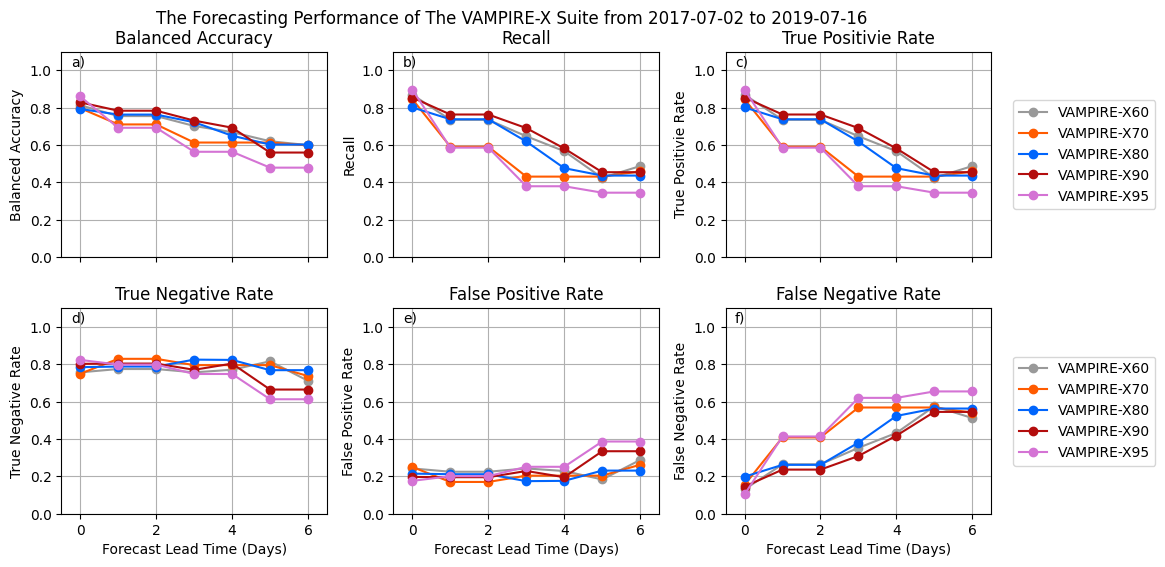

In [ ]:
#A 6-panel plot where each panel shows the model performance by a different metric,


data_plots=6 #can be changed to the desired number of panels must be larger than number of columns , currently set to the number of metrics
max_col=3 # the desired number of columns, must be less than data_plots
full=False # used to mark whether each subplot will have a plot, start with it as false, if it remains false
           # if it remains false theres a little code to fill in 1 more panel



if data_plots%max_col ==0: #will there be any remaining panels if not set full as true,
                      #data_plots is the number of data rows/plots
    full=True

if full==True: #if its a full grid then the number of rows is xbins/no of columns
    rows=int(data_plots/max_col)
    fig,axs=plt.subplots(nrows=rows,ncols=max_col,figsize=(4*max_col,3*rows),sharex=True)
else: #if it is not a full grid, we need an extra row
    rows=int(data_plots/max_col)+1
    fig,axs=plt.subplots(nrows=rows,ncols=max_col,figsize=(4*max_col,3*rows),sharex=True)
plt.subplots_adjust(hspace=0.25, wspace=0.25)
#set the row and column values to 0

model_name_list=['VAMPIRE-X60','VAMPIRE-X70','VAMPIRE-X80','VAMPIRE-X90','VAMPIRE-X95']

colours=['#999999','#ff5b00','#0165fc','#b30d0d','#D473D4']

for model in range(0,5):
  metrics=[full_balanced_accuracy_list[model],full_recall_list[model],full_tpr_list[model],full_tnr_list[model],full_fpr_list[model],full_fnr_list[model]]
  labels=['Balanced Accuracy', 'Recall', 'True Positivie Rate', 'True Negative Rate', 'False Positive Rate', 'False Negative Rate']
  leadtimes=[0,1,2,3,4,5,6]

  row=0
  col=0
  annotes=['a)','b)','c)','d)','e)','f)']

  for plot in range(0,data_plots): #loop over all the data that needs plotting

      label=labels[plot] # used in the title, but built here for tidyness
      #actually plot the data
      axs[row,col].plot(leadtimes,metrics[plot],color=colours[model],marker='o',label=model_name_list[model])
      axs[row,col].set_title(label)
      axs[row,col].grid()
      axs[row,col].set_xlim(-0.5,6.5)
      axs[row,col].set_ylim(0,1.1)
      axs[row,col].set_xlabel(r'')
      axs[row,col].set_ylabel(label)
      if model==0:
        axs[row,col].text(-0.25,1.025,annotes[plot])


      #axs[row,col].legend()
      #if we have not reached the final column move to the next one
      if col<max_col-1:
          col=col+1
      else: # if we have reached the final column, move to the first column on a new row
          axs[row,col].legend(loc='center',bbox_to_anchor=(1.35,0.5))
          row=row+1
          col=0

  if full==False: #if there isnt a full grid this fills the next (and most likely final) panel with another plot
      axs[row,col].plot()


  #then just make the overall title and save

  for i in range(0,max_col):
      axs[row-1,i].set_xlabel(r'Forecast Lead Time (Days)')


fig.suptitle(r'',fontsize=40,y=0.93)
fig.suptitle('The Forecasting Performance of The VAMPIRE-X Suite from '+Start+' to '+End ,y=0.95)
plt.show()
plt.close()



# Plotting Select Confusion Matrices

The following blocks will plot confusion matrices determined by the matrices_to_plot list.
This can be edited to the models/lead times on interest by adding/editing the individual elements. For each model and lead time you wish to plot a confusion matrix for, add a list containing two elements, the first will determine the model this should be one of the following options:
*   0 for VAMPIRE-X60
*   1 for VAMPIRE-X70
*   2 for VAMPIRE-X80
*   3 for VAMPIRE-X90
*   4 for VAMPIRE-X95

the second should be a number between 0 and 6, this is the lead time in days.

For Example:

matrices_to_plot=[[0,0],
                  [4,0],
                  [2,6]
                  ]

Would be the matrices for the VAMPIRE-X60 with a 0-day lead time, a the VAMPIRE-X95 with a 0-day lead time and the VAMPIRE-X80 for a 6-day lead time







In [ ]:
### Edit to select which confusion matrices you wish to plot

matrices_to_plot=[[0,0],[4,0],[2,6]]

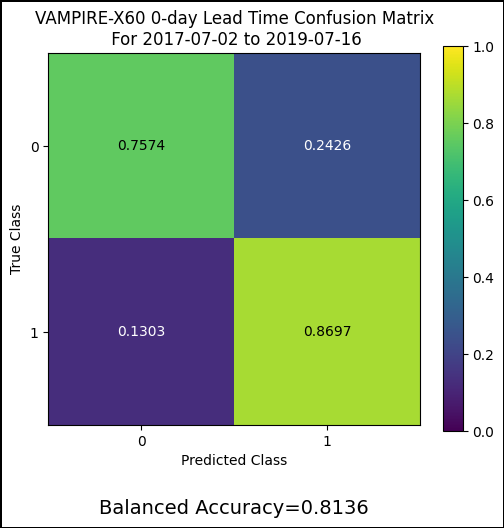

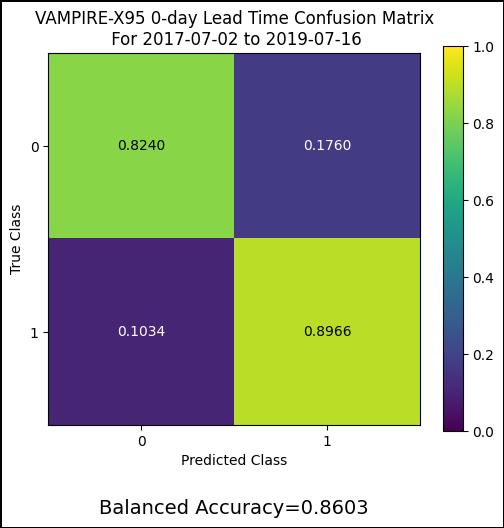

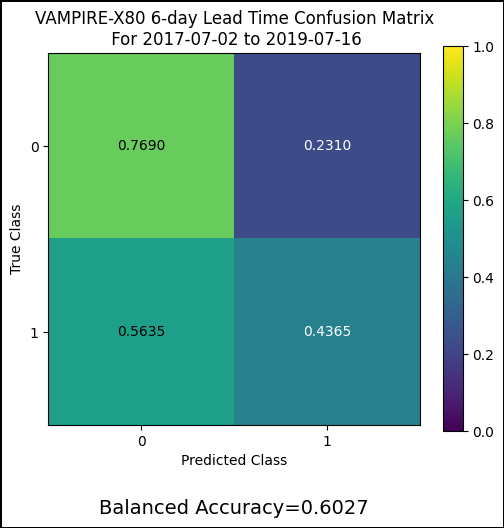

In [ ]:
## Plot Selected Confusion Matrices

#Fill this list with the specific forecasts you would like

ticks=[0,1]
labels=['0','1']
model_names=['VAMPIRE-X60','VAMPIRE-X70','VAMPIRE-X80','VAMPIRE-X90','VAMPIRE-X95']



for i in range(0,len(matrices_to_plot)):
  cm=full_CM_list[matrices_to_plot[i][0]][matrices_to_plot[i][1]]

  fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(6,5))

  im=ax.imshow(cm,vmin=0,vmax=1)

  ax.set_ylabel('True')
  for k in range(0,2):
      for j in range(0,2):
          if cm[k,j]<0.5:
              ax.text(j,k,str('%.4f'%cm[k,j]),color='white',horizontalalignment='center',verticalalignment='center')
          else:
              ax.text(j,k,str('%.4f'%cm[k,j]),horizontalalignment='center',verticalalignment='center')
  ax.set_xlabel('Predicted Class')
  ax.set_ylabel('True Class')
  ax.set_title(model_names[matrices_to_plot[i][0]]+' '+str(matrices_to_plot[i][1])+'-day Lead Time Confusion Matrix\n For '+Start+' to '+End)
  ax.set_xticks(ticks=ticks,labels=labels)
  ax.set_yticks(ticks=ticks,labels=labels)
  ax.text(0.5,1.95,s='Balanced Accuracy='+'%.4f'%full_balanced_accuracy_list[matrices_to_plot[i][0]][matrices_to_plot[i][1]],fontsize=14,horizontalalignment='center',verticalalignment='center')
  fig.colorbar(im)
  fig.patch.set_linewidth(2)
  fig.patch.set_edgecolor('black')
  plt.show()
  plt.close()
  print('   ')


